# HalfCheetah TD3

### Imports

In [1]:
import gymnasium as gym
import numpy as np
import torch
import matplotlib.pyplot as plt
from td3_src.td3 import TD3
from td3_src.replay import ReplayBuffer
from tqdm.notebook import trange
from IPython.display import Video
import pickle

### Environment Setup and Hyperparameters

In [ ]:
env = gym.make("HalfCheetah-v5")
eval_env = gym.make(
    "HalfCheetah-v5", render_mode="rgb_array", ctrl_cost_weight=0.7)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]

# Hyperparameters
total_timesteps = 2_000_000
start_timesteps = 50_000
eval_freq = 20_000  
max_ep_len = 1000
batch_size = 256
replay_size = 1_000_000
expl_noise = 0.1

device = 'cpu'
print("using device: " + str(device))

replay_buffer = ReplayBuffer(obs_dim, act_dim, replay_size)

agent = TD3(obs_dim, act_dim, act_limit, device=device)

using device: cpu


### Training Loop

In [ ]:
episode_rewards = []
eval_returns = []
obs, _ = env.reset()
episode_reward = 0
episode_timesteps = 0
episode_num = 0

pbar = trange(1, total_timesteps + 1, desc="Training")
for t in pbar:

    episode_timesteps += 1

    if t < start_timesteps:
        action = env.action_space.sample()
    else:
        action = agent.select_action(obs, noise_scale=expl_noise)

    next_obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    done_float = float(done)

    replay_buffer.store(obs, action, reward, next_obs, done_float)

    obs = next_obs
    episode_reward += reward

    if t >= start_timesteps:
        agent.update(replay_buffer, batch_size)

    if done:
        print(
            f"Total Timesteps: {t} | Episode: {episode_num} | Ep Reward: {episode_reward:.2f}")
        episode_rewards.append(episode_reward)
        obs, _ = env.reset()
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1

    if t % eval_freq == 0:
        eval_obs, _ = eval_env.reset()
        total_eval_reward = 0
        for _ in range(max_ep_len):
            eval_action = agent.select_action(eval_obs, noise_scale=0.0)
            eval_obs, r, terminated, truncated, _ = eval_env.step(eval_action)
            total_eval_reward += r
            if terminated or truncated:
                break
        print(f"Eval at {t} steps: {total_eval_reward:.2f}")
        eval_returns.append((t, total_eval_reward))

        if total_eval_reward >= 9000:
            print(
                f"Early stopping triggered at step {t}, Eval Reward Greater Than 9000: {total_eval_reward:.2f}")

            break

In [ ]:

agent.save("models/td3_halfcheetah_final")

with open("logs/episode_rewards.pkl", "wb") as f:
    pickle.dump(episode_rewards, f)

with open("logs/eval_returns.pkl", "wb") as f:
    pickle.dump(eval_returns, f)


In [3]:
agent.load("models/td3_halfcheetah_final")

with open("logs/episode_rewards.pkl", "rb") as f:
    episode_rewards = pickle.load(f)

with open("logs/eval_returns.pkl", "rb") as f:
    eval_returns = pickle.load(f)

### Plotting Eval Rewards Graph

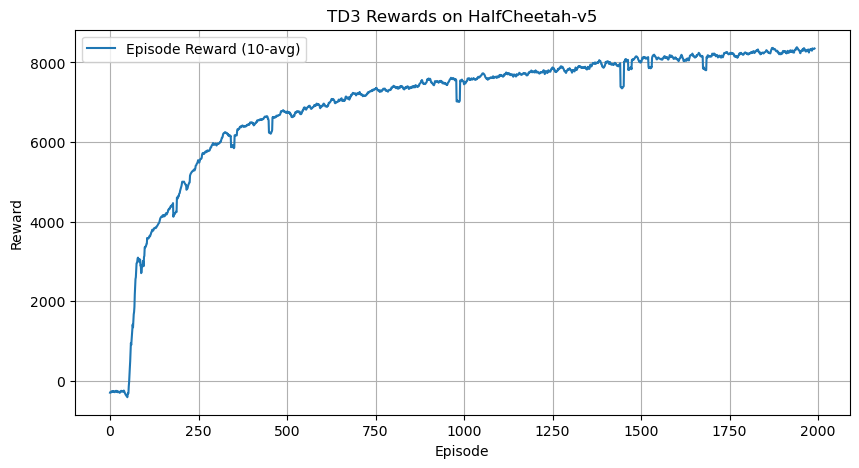

In [8]:
def moving_avg(data, window=10):
    return np.convolve(data, np.ones(window)/window, mode='valid')


plt.figure(figsize=(10, 5))
plt.plot(moving_avg(episode_rewards), label="Episode Reward (10-avg)")
# plt.plot(episode_rewards, label="Episode Reward")
eval_x, eval_y = zip(*eval_returns)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.title("TD3 Rewards on HalfCheetah-v5")
plt.savefig("td3_rewards.png")
plt.show()


### Record, Save, Display Agent Eval Video

In [5]:
import imageio


def record_eval_video(agent, env_name="HalfCheetah-v5", path="td3_eval.mp4", max_steps=500):
    env = gym.make(env_name, render_mode="rgb_array")
    obs, _ = env.reset()
    frames = []

    for _ in range(max_steps):
        action = agent.select_action(obs, noise_scale=0.0)
        obs, _, terminated, truncated, _ = env.step(action)
        frame = env.render()
        frames.append(frame)
        if terminated or truncated:
            break

    env.close()
    imageio.mimsave(path, frames, fps=30)
    print(f"Video saved")


record_eval_video(agent)
Video("td3_eval.mp4", embed=True)

Video saved


### Plotting Benchmark Rewards Graph

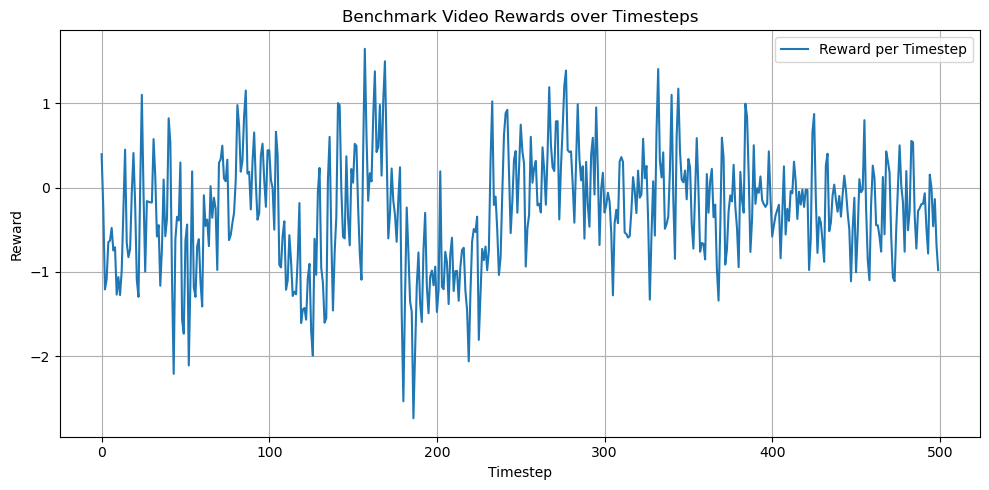

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(benchmark_rewards, label="Reward per Timestep")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.title("Benchmark Video Rewards over Timesteps")
plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig("td3_benchmark_reward_plot.png")
plt.show()

### Record, Save, Display Benchmark Env Video

In [6]:
import gymnasium as gym
import imageio


def record_env_video(env_name="HalfCheetah-v5", path="td3_benchmark_env.mp4", max_steps=500):
    env = gym.make(env_name, render_mode="rgb_array")
    obs, _ = env.reset()
    frames = []
    rewards = []

    for _ in range(max_steps):
        action = env.action_space.sample()
        obs, r, terminated, truncated, _ = env.step(action)
        rewards.append(r)
        frames.append(env.render())
        if terminated or truncated:
            break

    env.close()
    imageio.mimsave(path, frames, fps=30)
    print(f"Video saved as {path}")
    return rewards


benchmark_rewards = record_env_video()
Video("td3_benchmark_env.mp4", embed=True)

Video saved as td3_benchmark_env.mp4
